In [83]:
import torch
import pandas as pd
from scipy.spatial.distance import cosine, pdist, squareform, euclidean
from torch.nn.functional import cosine_similarity
import seaborn
import matplotlib.pyplot as plt
from transformers import WhisperTokenizer

In [2]:
ft_embed_path='../../data/langtok_experiment/ft_embed_tokens.pt'
med_embed_path='../../data/langtok_experiment/med_embed_tokens.pt'

In [3]:
ft_embeds=torch.load(ft_embed_path).weight.detach()
med_embeds=torch.load(med_embed_path).weight.detach()
ft_embeds.shape, med_embeds.shape

(torch.Size([51865, 1024]), torch.Size([51865, 1024]))

In [4]:
tok=WhisperTokenizer.from_pretrained('openai/whisper-medium')
nonlang_additional_special_tokens=[
    '<|endoftext|>',
    '<|startoftranscript|>',
    '<|translate|>',
    '<|transcribe|>',
    '<|startoflm|>',
    '<|startofprev|>',
    '<|nocaptions|>',
    '<|notimestamps|>',
]
lang_tokens = [
    tok for tok in tok.special_tokens_map['additional_special_tokens']
    if tok not in nonlang_additional_special_tokens
]
lang_ids = tok.convert_tokens_to_ids(lang_tokens)
lang_ids


[50259,
 50260,
 50261,
 50262,
 50263,
 50264,
 50265,
 50266,
 50267,
 50268,
 50269,
 50270,
 50271,
 50272,
 50273,
 50274,
 50275,
 50276,
 50277,
 50278,
 50279,
 50280,
 50281,
 50282,
 50283,
 50284,
 50285,
 50286,
 50287,
 50288,
 50289,
 50290,
 50291,
 50292,
 50293,
 50294,
 50295,
 50296,
 50297,
 50298,
 50299,
 50300,
 50301,
 50302,
 50303,
 50304,
 50305,
 50306,
 50307,
 50308,
 50309,
 50310,
 50311,
 50312,
 50313,
 50314,
 50315,
 50316,
 50317,
 50318,
 50319,
 50320,
 50321,
 50322,
 50323,
 50324,
 50325,
 50326,
 50327,
 50328,
 50329,
 50330,
 50331,
 50332,
 50333,
 50334,
 50335,
 50336,
 50337,
 50338,
 50339,
 50340,
 50341,
 50342,
 50343,
 50344,
 50345,
 50346,
 50347,
 50348,
 50349,
 50350,
 50351,
 50352,
 50353,
 50354,
 50355,
 50356,
 50357]

In [5]:
sw_tok_id = tok.encode('<|sw|>', add_special_tokens=False)[0]
sw_tok_id

50318

### Visualize similarity between language token embeddings

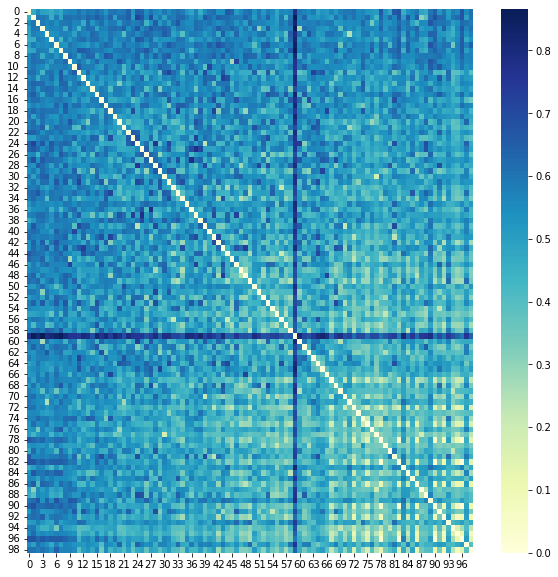

In [84]:
def dist_matrix(embeds_tensor, dist_func=cosine):
    dist_mat=squareform(pdist(embeds_tensor,dist_func))
    dist_mat.shape
    dist_df=pd.DataFrame(dist_mat)
    fig, ax = plt.subplots(figsize=(10,10))
    seaborn.heatmap(dist_df, cmap='YlGnBu')
dist_matrix(ft_embeds[lang_ids])

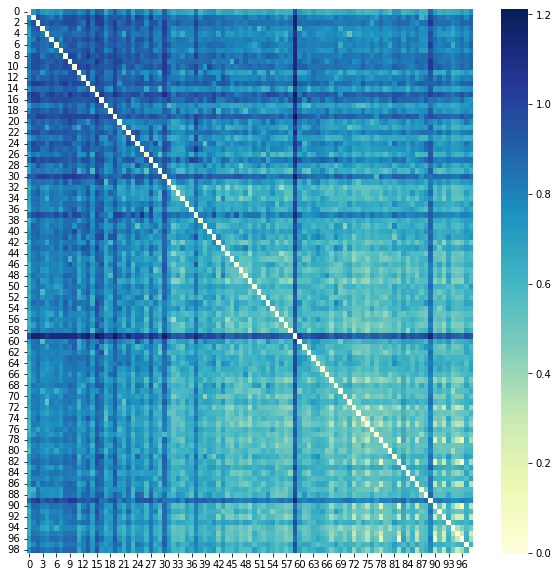

In [85]:
dist_matrix(ft_embeds[lang_ids], dist_func=euclidean)

### Compare average cosine distance from mean embedding for lang token embeddings and all other embeddings

In [7]:
avg_embed = med_embeds.mean(dim=0)
avg_lang_id = med_embeds[lang_ids].mean(dim=0)
avg_embed.shape, avg_lang_id.shape

(torch.Size([1024]), torch.Size([1024]))

In [67]:
tira_embed = ft_embeds[sw_tok_id]
sw_embed = med_embeds[sw_tok_id]
tira_sw_dist=cosine_similarity(tira_embed, sw_embed, dim=0).item()
tira_avg_dist=cosine_similarity(tira_embed, avg_embed, dim=0).item()
tira_lid_dist=cosine_similarity(tira_embed, avg_lang_id, dim=0).item()
sw_avg_dist=cosine_similarity(sw_embed, avg_embed, dim=0).item()
sw_lid_dist=cosine_similarity(sw_embed, avg_lang_id, dim=0).item()
print(f'{tira_sw_dist=:.3f}')
print(f'{tira_avg_dist=:.3f}')
print(f'{tira_lid_dist=:.3f}')
print(f'{sw_avg_dist=:.3f}')
print(f'{sw_lid_dist=:.3f}')

tira_sw_dist=0.224
tira_avg_dist=0.413
tira_lid_dist=0.368
sw_avg_dist=0.580
sw_lid_dist=0.717


In [56]:
med_embed_cos_sim=cosine_similarity(med_embeds, avg_embed)
med_langid_cos_sim=cosine_similarity(med_embeds, avg_lang_id)

ft_embed_cos_sim=cosine_similarity(ft_embeds, avg_embed)
ft_langid_cos_sim=cosine_similarity(ft_embeds, avg_lang_id)


In [58]:
print(f'mean\t{med_embed_cos_sim[lang_ids].mean().item():.3f}')
print(f'std\t{med_embed_cos_sim[lang_ids].std().item():.3f}')
print(f'min\t{med_embed_cos_sim[lang_ids].min().item():.3f}')
print(f'max\t{med_embed_cos_sim[lang_ids].max().item():.3f}')
print(f'tira\t{ft_embed_cos_sim[sw_tok_id].item():.3f}')

mean	0.597
std	0.143
min	0.358
max	0.963
tira	0.413


In [60]:
print(f'mean\t{med_langid_cos_sim[lang_ids].mean().item():.3f}')
print(f'std\t{med_langid_cos_sim[lang_ids].std().item():.3f}')
print(f'min\t{med_langid_cos_sim[lang_ids].min().item():.3f}')
print(f'max\t{med_langid_cos_sim[lang_ids].max().item():.3f}')
print(f'tira\t{ft_langid_cos_sim[sw_tok_id].item():.3f}')

mean	0.718
std	0.064
min	0.600
max	0.863
tira	0.368


In [15]:
torch.save(avg_lang_id, '../../data/langtok_experiment/avg_lang_id_embed.pt')

## Look at Euclidean distance instead of cosine distance

In [78]:
calc_euc=lambda a,b,dim: torch.sqrt(torch.sum(torch.pow(torch.subtract(a, b), 2), dim=dim))

In [79]:
tira_sw_dist=calc_euc(tira_embed, sw_embed, dim=0).item()
tira_avg_dist=calc_euc(tira_embed, avg_embed, dim=0).item()
tira_lid_dist=calc_euc(tira_embed, avg_lang_id, dim=0).item()
sw_avg_dist=calc_euc(sw_embed, avg_embed, dim=0).item()
sw_lid_dist=calc_euc(sw_embed, avg_lang_id, dim=0).item()
print(f'{tira_sw_dist=:.3f}')
print(f'{tira_avg_dist=:.3f}')
print(f'{tira_lid_dist=:.3f}')
print(f'{sw_avg_dist=:.3f}')
print(f'{sw_lid_dist=:.3f}')

tira_sw_dist=0.966
tira_avg_dist=0.822
tira_lid_dist=0.852
sw_avg_dist=0.506
sw_lid_dist=0.428


In [99]:
euc = calc_euc(ft_embeds, avg_embed,dim=1)
print(f'shape\t{euc.shape[0]}')
print(f'mean\t{euc.mean().item():.3f}')
print(f'std\t{euc.std().item():.3f}')
print(f'min\t{euc.min().item():.3f}')
print(f'max\t{euc.max().item():.3f}')
print(f'penmax\t{euc.sort(descending=True).values[1]:.3f}')
print(f'tira\t{euc[sw_tok_id].item():.3f}')

shape	51865
mean	0.230
std	0.036
min	0.142
max	0.905
penmax	0.894
tira	0.822


In [98]:
euc_med = calc_euc(med_embeds, avg_embed,dim=1)
print(f'shape\t{euc_med.shape[0]}')
print(f'mean\t{euc_med.mean().item():.3f}')
print(f'std\t{euc_med.std().item():.3f}')
print(f'min\t{euc_med.min().item():.3f}')
print(f'max\t{euc_med.max().item():.3f}')
print(f'penmax\t{euc_med.sort(descending=True).values[1]:.3f}')
print(f'tira\t{euc[sw_tok_id].item():.3f}')

shape	51865
mean	0.230
std	0.036
min	0.142
max	0.905
penmax	0.894
tira	0.822


In [97]:
print(f'shape\t{euc_med[lang_ids].shape[0]}')
print(f'mean\t{euc_med[lang_ids].mean().item():.3f}')
print(f'std\t{euc_med[lang_ids].std().item():.3f}')
print(f'min\t{euc_med[lang_ids].min().item():.3f}')
print(f'max\t{euc_med[lang_ids].max().item():.3f}')
print(f'penmax\t{euc_med[lang_ids].sort(descending=True).values[1]:.3f}')
print(f'tira\t{euc[sw_tok_id].item():.3f}')

shape	99
mean	0.559
std	0.164
min	0.228
max	0.905
penmax	0.894
tira	0.822


In [96]:
euc_lid = calc_euc(ft_embeds, avg_lang_id,dim=1)
print(f'mean\t{euc_lid[lang_ids].mean().item():.3f}')
print(f'std\t{euc_lid[lang_ids].std().item():.3f}')
print(f'min\t{euc_lid[lang_ids].min().item():.3f}')
print(f'max\t{euc_lid[lang_ids].max().item():.3f}')
print(f'penmax\t{euc_lid[lang_ids].sort(descending=True).values[1]:.3f}')
print(f'tira\t{euc_lid[sw_tok_id].item():.3f}')

mean	0.494
std	0.128
min	0.293
max	0.852
penmax	0.776
tira	0.852
